<a href="https://colab.research.google.com/github/Eric-rWang/VivoX/blob/main/PPG_Lightweight_Transformer_Huber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lightweight Transformer Implementation

In [2]:
# imports
import os
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import time

os.chdir("/content/DATA")
print(os.getcwd())

/content/DATA


**Model Architecture:**

**Input:**
(batch_size, 1, 36, window_size) (36 channels: 12 locations × 3 wavelengths)

**Channel-wise Embedding:**
Stack of 1D convolutions and pooling compresses each channel’s temporal waveform into a single 256-dimensional feature vector.

**Transformer Encoder:**
A 2-layer Transformer encoder (with 4 attention heads) models relationships between these compressed features.

**Regression Head:**
Fully connected layers map the output to 2 values (SvO2 and SaO2).

**Flow:**
Input → Conv1d/Pooling → Feature Vector → Transformer → Output Head → Prediction

In [3]:
class LightweightTransformer(nn.Module):
    def __init__(self, num_channels=36, window_size=350):
        super().__init__()

        # 1. Channel-wise embedding with proper output dimension
        self.embed = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=4,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # 3. Output head
        self.head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        # Separate heads for SaO2 and SvO2
        self.head_sa = nn.Sequential(
            nn.LayerNorm(256),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )
        self.head_sv = nn.Sequential(
            nn.LayerNorm(256),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        # Input: (B, 1, C, T)
        x = x.squeeze(1)  # (B, C, T)
        x = self.embed(x)  # (B, 256, 1)
        x = x.squeeze(-1)  # (B, 256)
        x = x.unsqueeze(1)  # (B, 1, 256)
        x = self.transformer(x)  # (B, 1, 256)
        x = x.squeeze(1)  # (B, 256)

        return self.head(x)

        # sa_pred = self.head_sa(x)  # (B, 1)
        # sv_pred = self.head_sv(x)  # (B, 1)
        # out = torch.cat([sa_pred, sv_pred], dim=1)  # (B, 2)
        # return out

Supporting functions for script


In [4]:
def verify_model(model):
    model.eval()
    try:
        # Test with random data matching our expected input shape
        dummy_input = torch.randn(2, 1, 36, 350)
        output = model(dummy_input)
        assert output.shape == (2, 2), f"Bad output shape: {output.shape}"
        print(f"Model verification passed")
        return True
    except Exception as e:
        print(f"Model verification failed: {str(e)}")
        return False

In [5]:
def import_h5py(file_path):
  with h5py.File(file_path, 'r') as f:
      X = f['waveforms'][:]
      y = f['labels'][:]

      return X, y

Configurations

In [6]:
USE_SEPARATE_TEST_FILE = True  # Set to False to use single file approach

if USE_SEPARATE_TEST_FILE:
    train_val_file_path = "Shifting_Positions_v4.0.h5"
    test_file_path = "Validation_v1.0.h5"
    print(f"Loading training/validation data from {train_val_file_path} ...")
    print(f"Loading test data from {test_file_path} ...")
else:
    file_path = "/content/DATA/jul14th_shift_sensor_data_eric.h5"
    print(f"Loading data from {file_path} ...")

save_dir = 'saved_models'
os.makedirs(save_dir, exist_ok=True)

Loading training/validation data from Shifting_Positions_v4.0.h5 ...
Loading test data from Validation_v1.0.h5 ...


Model hyperparameters

In [7]:
# Hyperparameters
num_channels = 36
window_size = 350
batch_size = 32
lr = 1e-4
weight_decay = 1e-4
num_epochs = 15 # was 300
n_patience = 50

# Models to train
MODELS = {
    "LightTransformer": LightweightTransformer
}

Data loading and preparation

In [8]:
# --- Data Loading and Preparation ---
if USE_SEPARATE_TEST_FILE:
    # Load training/validation data
    # Ensure we are in the correct directory before loading
    os.chdir("/content/DATA")
    train_val_file_path = "Shifting_Position_v4.0.h5"
    combined_data, labels_array = import_h5py(train_val_file_path)
    print(f"Training/Val data loaded ✅\nData shape: {combined_data.shape}, Labels shape: {labels_array.shape}")

    # Load test data separately
    test_file_path = "Validation_v1.0.h5"
    X_test, y_test = import_h5py(test_file_path)
    # X_test, y_test = import_h5py(test_file_path)
    print(f"Test data loaded ✅\nData shape: {X_test.shape}, Labels shape: {y_test.shape}")

    # Split the training/validation data into train and val (75/25 split)
    X_train, X_val, y_train, y_val = train_test_split(
        combined_data, labels_array,
        test_size=0.25,
        random_state=42
    )
else:
    # Original single file approach
    combined_data, labels_array = import_h5py(file_path)
    print(f"Loaded ✅\nData shape: {combined_data.shape}, Labels shape: {labels_array.shape}")

    # Use 100% of combined_data: 60% train, 20% val, 20% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        combined_data, labels_array,
        train_size=0.6,
        random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42
    )

print("Training data range:")
print(f"X_train: {X_train.min()} to {X_train.max()}")
print(f"y_train: {y_train.min()} to {y_train.max()}")
print("\nTest data range:")
print(f"X_test: {X_test.min()} to {X_test.max()}")
print(f"y_test: {y_test.min()} to {y_test.max()}")

Training/Val data loaded ✅
Data shape: (9940, 350, 36), Labels shape: (9940, 2)
Test data loaded ✅
Data shape: (915, 350, 36), Labels shape: (915, 2)
Training data range:
X_train: -173630.13649154917 to 213508.44104482824
y_train: 30 to 100

Test data range:
X_test: -10221.409632908988 to 9173.120933216334
y_test: 30 to 100


Diagnostic

In [9]:
# Diagnostic: original train‐set class counts
print(f"\nOriginal training set class counts:")
labels, counts = np.unique(y_train, axis=0, return_counts=True)
for lbl, cnt in zip(labels, counts):
    print(f"  {lbl.tolist()}: {cnt} samples")


Original training set class counts:
  [100, 30]: 1714 samples
  [100, 40]: 1352 samples
  [100, 50]: 1350 samples
  [100, 60]: 1335 samples
  [100, 70]: 1704 samples


Balancing

In [10]:
# --- Balance TRAINING SET only via median‐based under/oversampling ---
target = int(np.median(counts))
print(f"\nBalancing training set to {target} samples per class (median count)")
balanced_X, balanced_y = [], []

def jitter(x, σ=0.02):
    return x + np.random.normal(0, σ*np.std(x), size=x.shape)
def time_shift(x, max_shift=15):
    s = np.random.randint(-max_shift, max_shift+1)
    return np.roll(x, s, axis=0)

for lbl, cnt in zip(labels, counts):
    idxs = np.where((y_train == lbl).all(axis=1))[0]
    X_lbl = X_train[idxs]
    y_lbl = y_train[idxs]
    # undersample if too big
    if cnt > target:
        chosen = np.random.choice(idxs, target, replace=False)
        balanced_X.append(X_train[chosen])
        balanced_y.append(y_train[chosen])
    # oversample + augment if too small
    elif cnt < target:
        balanced_X.append(X_lbl)
        balanced_y.append(y_lbl)
        n_to_gen = target - cnt
        for _ in range(n_to_gen):
            i = np.random.choice(idxs)
            x_aug = time_shift(jitter(X_train[i]))
            balanced_X.append(x_aug[None])
            balanced_y.append(lbl[None])
    else:
        balanced_X.append(X_lbl)
        balanced_y.append(y_lbl)

# concatenate back
X_train = np.vstack(balanced_X)
y_train = np.vstack(balanced_y)


Balancing training set to 1352 samples per class (median count)


Post balancing diagnostic

In [11]:
# Diagnostic: neue training und test set Klassenquantitäten
print("Post‐balance training set class counts:")
new_labels, new_counts = np.unique(y_train, axis=0, return_counts=True)
for lbl, old_cnt, new_cnt in zip(labels, counts, new_counts):
    delta = new_cnt - old_cnt
    pct = delta/old_cnt*100
    print(f"  {lbl.tolist()}: {new_cnt} samples ({'+' if delta>=0 else ''}{delta}, {pct:.1f}%)")

Post‐balance training set class counts:
  [100, 30]: 1352 samples (-362, -21.1%)
  [100, 40]: 1352 samples (+0, 0.0%)
  [100, 50]: 1352 samples (+2, 0.1%)
  [100, 60]: 1352 samples (+17, 1.3%)
  [100, 70]: 1352 samples (-352, -20.7%)


Normalization


In [12]:
# Better input normalization (per‐channel)
def normalize_ppg(X):
    median = np.median(X, axis=2, keepdims=True)
    mad    = 1.4826 * np.median(np.abs(X - median), axis=2, keepdims=True)
    return (X - median) / (mad + 1e-6)

def global_normalize_ppg(X):
    """
    Normalize each sample in X using global min-max across all channels and time points.
    Args:
        X: np.ndarray of shape (N, C, T)
    Returns:
        X_norm: np.ndarray of shape (N, C, T)
    """
    X_min = X.min(axis=(1, 2), keepdims=True)  # shape (N, 1, 1)
    X_max = X.max(axis=(1, 2), keepdims=True)  # shape (N, 1, 1)
    X_norm = (X - X_min) / (X_max - X_min + 1e-6)
    return X_norm

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

X_train = global_normalize_ppg(X_train)
X_val   = global_normalize_ppg(X_val)
X_test  = global_normalize_ppg(X_test)

# Label normalization
y_max   = 100.0
y_train = y_train / y_max
y_val   = y_val   / y_max
y_test  = y_test  / y_max

print("Post-scaling X range:", X_train.min(), X_train.max())
print("Post-scaling y range:", y_train.min(), y_train.max())

(6760, 350, 36)
(2485, 350, 36)
(915, 350, 36)
Post-scaling X range: 0.0 0.9999999999970896
Post-scaling y range: 0.3 1.0


In [13]:
# Save the splits for later
np.savez(os.path.join(save_dir, 'data_splits.npz'),
         X_train=X_train, y_train=y_train,
         X_val=X_val,     y_val=y_val,
         X_test=X_test,   y_test=y_test)

In [14]:
# Convert to tensors and reshape
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_val_t = torch.from_numpy(X_val).float()
y_val_t = torch.from_numpy(y_val).float()
X_test_t = torch.from_numpy(X_test).float()
y_test_t = torch.from_numpy(y_test).float()

In [15]:
# Reshape to (N, 1, 36, 350)
X_train_rs = X_train_t.permute(0, 2, 1).unsqueeze(1)
X_val_rs = X_val_t.permute(0, 2, 1).unsqueeze(1)
X_test_rs = X_test_t.permute(0, 2, 1).unsqueeze(1)

In [16]:
# Normalize using only training statistics und so
mean = X_train_rs.mean(dim=(0, 1, 3), keepdim=True)
std = X_train_rs.std(dim=(0, 1, 3), keepdim=True)
X_train_rs = (X_train_rs - mean) / (std + 1e-6)
X_val_rs = (X_val_rs - mean) / (std + 1e-6)
X_test_rs = (X_test_rs - mean) / (std + 1e-6)

In [17]:
# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_rs, y_train_t), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_rs, y_val_t), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_rs, y_test_t), batch_size=batch_size)

In [18]:
# --- Training Loop für alle Modelle ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("🍏 Using Apple Silicon GPU (MPS)")
else:
    device = torch.device('cpu')
    print("💀 Falling back to CPU? Yikes!")

for model_name, model_class in MODELS.items():

    print(f"\n=== Training {model_name} ===")
    model = model_class(
        num_channels=num_channels,
        window_size=window_size
    ).to(device)

    # criterion = nn.MSELoss()
    # Replace MSELoss with SmoothL1Loss
    criterion = nn.SmoothL1Loss()

    # Example weights (adjust as needed)
    w_sa, w_sv = 1.0, 1.2


    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    test_losses = []  # für jede epoch den test loss speichern aber halt auch den g (Max is Deutsch)
    epoch_times = []  # Track epoch durations

    best_test_preds = []
    best_test_targets = []

    for epoch in range(1, num_epochs + 1):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        for Xb, yb in train_loader:
            # Xb, yb = Xb.to(device), yb.to(device)
            # optimizer.zero_grad()
            # preds = model(Xb)
            # loss = criterion(preds, yb)
            # loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            # optimizer.step()
            # epoch_train_loss += loss.item() * Xb.size(0)
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(Xb)
            # Compute per-target loss
            loss_sa = criterion(preds[:, 0], yb[:, 0])
            loss_sv = criterion(preds[:, 1], yb[:, 1])
            loss = w_sa * loss_sa + w_sv * loss_sv
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item() * Xb.size(0)
        train_losses.append(epoch_train_loss / len(train_loader.dataset))

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                epoch_val_loss += criterion(model(Xb), yb).item() * Xb.size(0)
        val_losses.append(epoch_val_loss / len(val_loader.dataset))

        # TEST PHASE - NOW EVALUATED EVERY EPOCH
        test_preds = []
        test_targets = []

        epoch_test_loss = 0.0
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb)
                test_preds.append(preds.cpu().numpy())
                test_targets.append(yb.cpu().numpy())
                epoch_test_loss += criterion(model(Xb), yb).item() * Xb.size(0)
        test_losses.append(epoch_test_loss / len(test_loader.dataset))

        # Concatenate all batches
        test_preds = np.concatenate(test_preds, axis=0)  # shape: (N, 2)
        test_targets = np.concatenate(test_targets, axis=0)  # shape: (N, 2)

        # Calculate epoch duration and ETA; einfach nur für den aktuellen Epoch
        epoch_duration = time.time() - epoch_start_time
        epoch_times.append(epoch_duration)

        # Calculate ETA based on average epoch time
        avg_epoch_time = np.mean(epoch_times)
        remaining_epochs = num_epochs - epoch
        eta_seconds = remaining_epochs * avg_epoch_time
        eta_mins = eta_seconds / 60

        # Update scheduler and early stopping
        scheduler.step(val_losses[-1])
        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            patience_counter = 0
            status = ''
            best_test_preds = test_preds
            best_test_targets = test_targets
        else:
            patience_counter += 1
            status = '⚪️'
            if patience_counter >= n_patience:
                print(f"\nEarly stopping triggered at epoch {epoch}!")
                break

        print(f"{status} {model_name} Epoch {epoch:3d}: Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f} | Test {test_losses[-1]:.4f} | {epoch_duration:.1f}s/epoch | ETA: {eta_mins:.1f}mins ({eta_seconds:.0f}s)")

    print(f"\n{model_name} Training complete!")
    print(f"Best val loss: {best_val_loss:.4f}")

    # Save model and training history
    torch.save({
        'model_state': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'test_losses': test_losses,  # Full test loss trajectory - weil wir es jetzt jedes Epoch speichern
        'config': {
            'num_channels': num_channels,
            'window_size': window_size,
            'model_name': model_name
        }
    }, os.path.join(save_dir, f'{model_name}.pt'))

print("\nAll models trained and saved!")

🚀 Using GPU: Tesla T4

=== Training LightTransformer ===
 LightTransformer Epoch   1: Train 0.0116 | Val 0.0012 | Test 0.0036 | 4.1s/epoch | ETA: 1.0mins (58s)
 LightTransformer Epoch   2: Train 0.0019 | Val 0.0003 | Test 0.0042 | 2.2s/epoch | ETA: 0.7mins (41s)
⚪️ LightTransformer Epoch   3: Train 0.0010 | Val 0.0003 | Test 0.0044 | 2.1s/epoch | ETA: 0.6mins (34s)
 LightTransformer Epoch   4: Train 0.0007 | Val 0.0002 | Test 0.0048 | 2.1s/epoch | ETA: 0.5mins (29s)
 LightTransformer Epoch   5: Train 0.0006 | Val 0.0002 | Test 0.0044 | 2.2s/epoch | ETA: 0.4mins (26s)
⚪️ LightTransformer Epoch   6: Train 0.0004 | Val 0.0002 | Test 0.0051 | 2.2s/epoch | ETA: 0.4mins (22s)
 LightTransformer Epoch   7: Train 0.0004 | Val 0.0001 | Test 0.0045 | 2.2s/epoch | ETA: 0.3mins (20s)
 LightTransformer Epoch   8: Train 0.0003 | Val 0.0001 | Test 0.0042 | 2.1s/epoch | ETA: 0.3mins (17s)
⚪️ LightTransformer Epoch   9: Train 0.0003 | Val 0.0001 | Test 0.0046 | 2.2s/epoch | ETA: 0.2mins (14s)
 LightTran

Plots

=== Summary (Held-Out Phantom) ===
[{'Bias': 0.006423841017842945,
  'LoA_high': 0.018481973973824787,
  'LoA_low': -0.005634291938138897,
  'MAE': 0.007415574495909644,
  'N': 915,
  'R2': -72351621021.02252,
  'RMSE': 0.008892289348651106,
  'SD_diff': 0.006152108651011143,
  'target': 'SaO2'},
 {'Bias': 0.0372013908461795,
  'LoA_high': 0.300055562013037,
  'LoA_low': -0.22565278032067798,
  'MAE': 0.12231153893991899,
  'N': 915,
  'R2': 0.011713336630704507,
  'RMSE': 0.13910278210070398,
  'SD_diff': 0.13410927100349873,
  'target': 'SvO2'}]


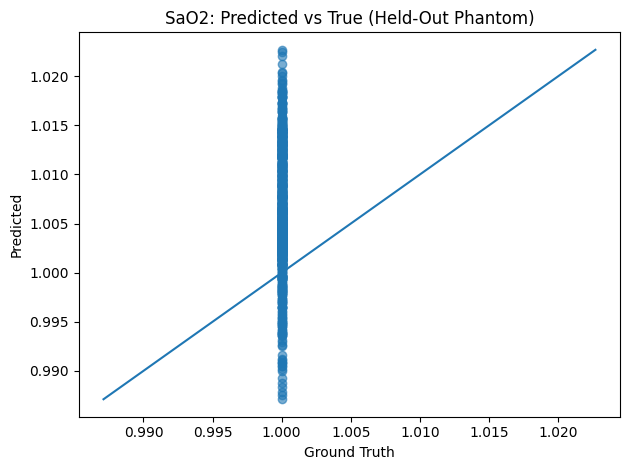

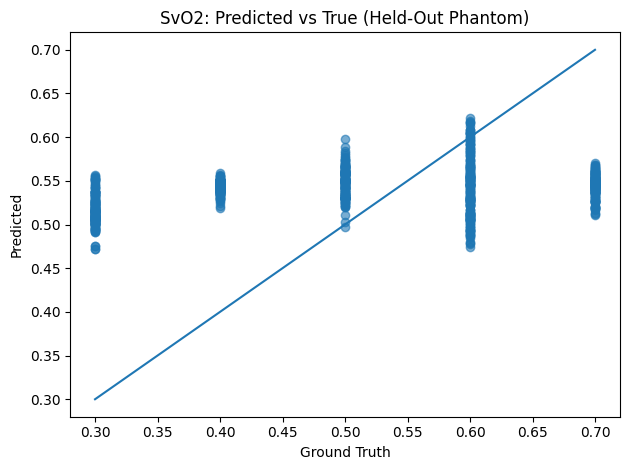

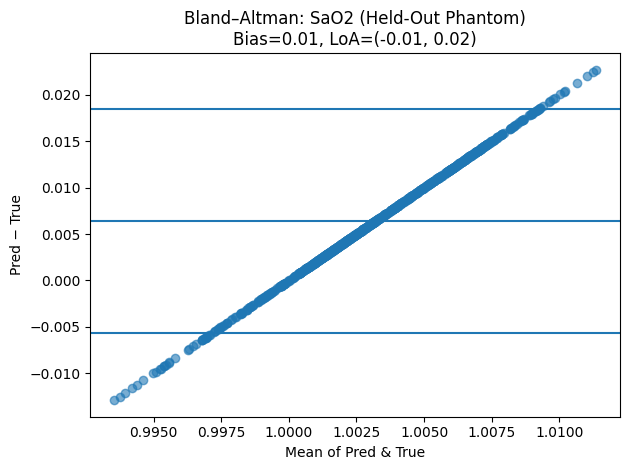

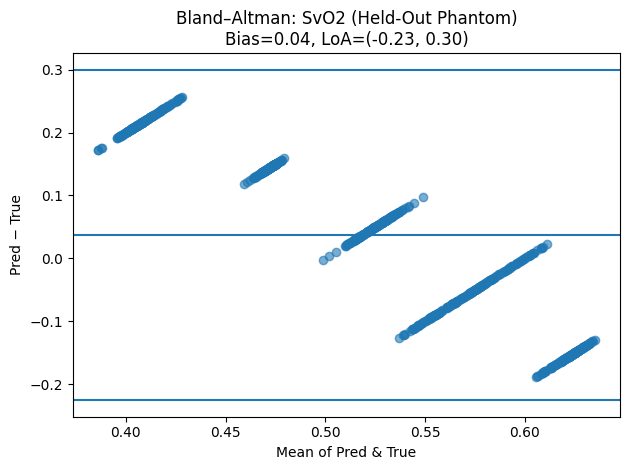

/tmp/ipython-input-3343298967.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[str(k) for k in keys], showmeans=True)


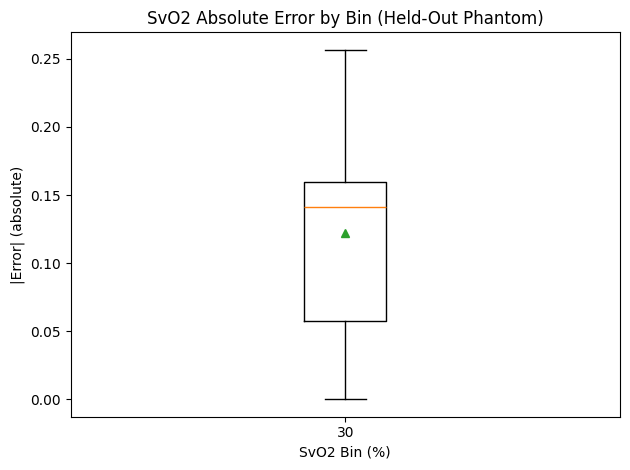

Saved figures: scatter_sa.png, scatter_sv.png, ba_sa.png, ba_sv.png, sv_box_abs_err.png


In [20]:
# === CONFIG / AUTODETECT ===
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from collections import defaultdict

# Try to auto-detect predictions and ground truth commonly used names
globals_dict = globals()
Y_TRUE = best_test_targets
Y_PRED = best_test_preds

candidates_true = ["y_test", "Y_test", "y_true", "Y_true", "y_test_all", "Y_TEST"]
candidates_pred = ["y_pred", "Y_pred", "preds_test", "Y_PRED", "yhat_test", "y_test_pred"]

def _pick(name_list):
    for n in name_list:
        if n in globals_dict:
            arr = globals_dict[n]
            try:
                a = np.asarray(arr)
                if a.ndim == 2 and a.shape[1] in (2,):
                    return a
            except Exception:
                pass
    return None

Y_TRUE = _pick(candidates_true)
Y_PRED = _pick(candidates_pred)

# If not found, define placeholders for manual assignment here:
# Example:
# Y_TRUE = np.load("y_true_test.npy")   # shape (N,2)
# Y_PRED = np.load("y_pred_test.npy")   # shape (N,2)

assert Y_TRUE is not None and Y_PRED is not None, "Please set Y_TRUE and Y_PRED as (N,2) arrays before running."

# Sanity checks
assert Y_TRUE.shape == Y_PRED.shape and Y_TRUE.shape[1] == 2, f"Mismatch: {Y_TRUE.shape} vs {Y_PRED.shape}"

# Ensure numeric
Y_TRUE = np.asarray(Y_TRUE, dtype=float)
Y_PRED = np.asarray(Y_PRED, dtype=float)

# === Metrics helpers ===
def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_pred - y_true)))

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((y_pred - y_true)**2)))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1.0 - ss_res / (ss_tot + 1e-12))

def bland_altman(y_true, y_pred):
    diff = y_pred - y_true
    mean = (y_pred + y_true) / 2.0
    bias = np.mean(diff)
    sd = np.std(diff, ddof=1)
    loa_low = bias - 1.96*sd
    loa_high = bias + 1.96*sd
    return mean, diff, bias, sd, loa_low, loa_high

def summarize_target(name, y_true, y_pred):
    _mae = mae(y_true, y_pred)
    _rmse = rmse(y_true, y_pred)
    _r2 = r2(y_true, y_pred)
    _, _, bias, sd, lo, hi = bland_altman(y_true, y_pred)
    return {
        "target": name,
        "N": int(len(y_true)),
        "MAE": _mae,
        "RMSE": _rmse,
        "R2": _r2,
        "Bias": float(bias),
        "LoA_low": float(lo),
        "LoA_high": float(hi),
        "SD_diff": float(sd)
    }

# === Compute summaries ===
sa_true = Y_TRUE[:,0]; sa_pred = Y_PRED[:,0]
sv_true = Y_TRUE[:,1]; sv_pred = Y_PRED[:,1]

summary = [
    summarize_target("SaO2", sa_true, sa_pred),
    summarize_target("SvO2", sv_true, sv_pred),
]

# Print summary table
from pprint import pprint
print("=== Summary (Held-Out Phantom) ===")
pprint(summary)

# === Utility: create SvO2 bins (30–70 in steps of 10) ===
def sv_bins(v):
    # Round to nearest 10 within 30..70
    b = np.clip(10*np.round(v/10.0), 30, 70)
    return b.astype(int)

sv_bin = sv_bins(sv_true)

# === Scatter / Calibration plots ===
def scatter_plot(y_true, y_pred, title, fname):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    # Identity line
    mn = min(np.min(y_true), np.min(y_pred))
    mx = max(np.max(y_true), np.max(y_pred))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Ground Truth")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

scatter_plot(sa_true, sa_pred, "SaO2: Predicted vs True (Held-Out Phantom)", "scatter_sa.png")
scatter_plot(sv_true, sv_pred, "SvO2: Predicted vs True (Held-Out Phantom)", "scatter_sv.png")

# === Bland–Altman plots ===
def bland_altman_plot(y_true, y_pred, title, fname):
    mean, diff, bias, sd, lo, hi = bland_altman(y_true, y_pred)
    plt.figure()
    plt.scatter(mean, diff, alpha=0.6)
    plt.axhline(bias)
    plt.axhline(lo)
    plt.axhline(hi)
    plt.xlabel("Mean of Pred & True")
    plt.ylabel("Pred − True")
    plt.title(f"{title}\nBias={bias:.2f}, LoA=({lo:.2f}, {hi:.2f})")
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

bland_altman_plot(sa_true, sa_pred, "Bland–Altman: SaO2 (Held-Out Phantom)", "ba_sa.png")
bland_altman_plot(sv_true, sv_pred, "Bland–Altman: SvO2 (Held-Out Phantom)", "ba_sv.png")

# === Stratified absolute error boxplots by SvO2 bin ===
def stratified_boxplot(y_true_sv, y_pred_sv, bins, title, fname):
    abs_err = np.abs(y_pred_sv - y_true_sv)
    groups = defaultdict(list)
    for e, b in zip(abs_err, bins):
        groups[int(b)].append(float(e))
    keys = sorted(groups.keys())
    data = [groups[k] for k in keys]

    plt.figure()
    plt.boxplot(data, labels=[str(k) for k in keys], showmeans=True)
    plt.xlabel("SvO2 Bin (%)")
    plt.ylabel("|Error| (absolute)")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(fname, dpi=200)
    plt.show()

stratified_boxplot(sv_true, sv_pred, sv_bin,
                   "SvO2 Absolute Error by Bin (Held-Out Phantom)",
                   "sv_box_abs_err.png")

print("Saved figures: scatter_sa.png, scatter_sv.png, ba_sa.png, ba_sv.png, sv_box_abs_err.png")
